# ADA final exam (winter semester 2019/2020)

A friend of yours wants to start a YouTube channel and ideally earn some money via ads. However, there are so many channels and videos out there that your friend has no idea where to even start. Fortunately, they know that you have taken ADA and think you might help them out by analyzing the videos that are currently on YouTube.

The data you are provided with is a subset of YouTube videos, with videos from some of the giant channels in two categories: "Gaming" and "How-to & Style", which are the categories your friend is choosing between. The dataset contains a lot of videos, with data on those videos including their titles, their total number of views in 2019, their tags and descriptions, etc. The data is, in gzip-compressed format, contained in the `data/` folder, as the file `youtube.csv.gz`.

The three tasks A, B and C are **independent** of each other, and you can solve any combination of them. The exam is designed for more than 3 hours, so don't worry if you don't manage to solve everything; you can still score a 6.

You need to run the following two cells to read and prepare the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
youtube = pd.read_csv('data/youtube.csv.gz', compression='gzip')
youtube.upload_date = pd.to_datetime(youtube.upload_date)

In [3]:
youtube.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat
0,PewDiePie,2013-03-04,A NEW ADVENTURE! - Kingdom Hearts (1) w/ Pewds,"['lets', 'play', 'horror', 'game', 'walkthroug...",1126.0,2541550.0,4.886102,720.0,1280.0,Gaming
1,PewDiePie,2013-03-04,SAVING PRIVATE PEWDS - Conker's Bad Fur Day (15),"['lets', 'play', 'horror', 'game', 'walkthroug...",903.0,1727646.0,4.951531,720.0,1280.0,Gaming
2,PewDiePie,2013-03-04,THE WORST SCARE! - Amnesia: Rain (4),"['lets', 'play', 'horror', 'game', 'walkthroug...",806.0,1402747.0,4.962706,720.0,1280.0,Gaming
3,PewDiePie,2013-03-03,Nova / Sp00n / Cry / Pewds - Worms Revolution ...,"['lets', 'play', 'horror', 'game', 'walkthroug...",909.0,4348296.0,4.937665,720.0,1280.0,Gaming
4,PewDiePie,2013-03-03,SEXIEST HORROR EVER - Amnesia: Rain (3),"['lets', 'play', 'horror', 'game', 'walkthroug...",834.0,1410659.0,4.957545,720.0,1280.0,Gaming


## Dataset description

Each row of the dataset corresponds to one video that was uploaded to YouTube. There are 11 columns:
'channel', 'upload_date', 'title', 'categories', 'tags', 'duration',
       'view_count', 'average_rating', 'height', 'width', 'channel_cat'.
- `channel`: The channel (account) on which the video was uploaded.
- `upload_date`: The date on which the video was uploaded (Pandas Timestamp object).
- `title`: The title of the video.
- `tags`: A list of words that describe the video.
- `duration`: The duration of the video in seconds.
- `view_count`: The number of times the video was watched.
- `average_rating`: The average score with which the viewers rated the video (1-5).
- `height`: The height of the video in pixels.
- `width`: The width of the video in pixels.
- `channel_cat`: The category of the channel on which this video was uploaded. This dataset only contains videos from channels from the 'Gaming' and the 'Howto & Style' category.

# Task A: Welcome to the exam!

All of Task A refers to the videos that were published between and including 2010 and 2018.

In [4]:
youtube_A = youtube.copy()
youtube_A['upload_date'] = pd.to_datetime(youtube_A['upload_date'])
youtube_A['upload_year'] = pd.DatetimeIndex(youtube_A['upload_date']).year
# Get only videos after 2009
youtube_A = youtube_A[youtube_A['upload_year'] > 2009]
# Get only videos before 2019
youtube_A = youtube_A[youtube_A['upload_year'] < 2019]
youtube_A.shape

(127863, 11)

## A1: A growing platform?

You would first like to know whether YouTube in general is the right platform to invest time into.

1. Using the appropriate plot type, plot the number of videos published per year between and including 2010 and 2018.

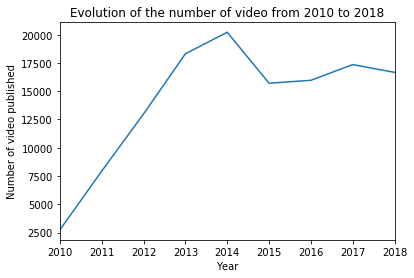

In [5]:
# Get the year and count the values
upload_year_counts = youtube_A['upload_year'].value_counts()
upload_year_counts = upload_year_counts.sort_index()

plt.figure()
upload_year_counts.plot()
plt.title("Evolution of the number of video from 2010 to 2018")
plt.xlabel("Year")
plt.ylabel("Number of video published")
plt.show()

We can see that the number of videos has gorwn linearly from 2010 to his peak in 2014 after hat it seems to be stabilized aroud 16 000 videos per year.

2. Now for each year, plot the number of channels that have been created between the beginning of 2010 and the end of that year. A channel is considered to be created at the time at which they upload their first video.

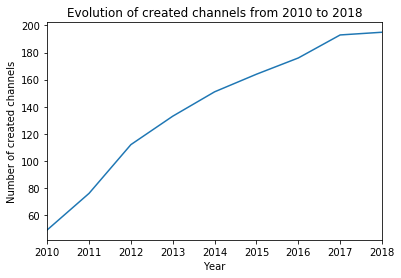

In [6]:
# Groupby channel and keep only the minmal year (the year where the first video have been published)
chanels = youtube_A.groupby('channel').agg(created_date=('upload_year', 'min'))

# Counts values
new_channels_counts = chanels['created_date'].value_counts()
new_channels_counts = new_channels_counts.sort_index()
# Take the cumulative sum, the number of channel created between beginning
# of 2010 and the end of the year
new_channels_counts = new_channels_counts.cumsum()

plt.figure()
new_channels_counts.plot()
plt.title("Evolution of created channels from 2010 to 2018")
plt.xlabel("Year")
plt.ylabel("Number of created channels")
plt.show()

We can see that the curve is concave, it means that the number of created channels each year decrease.

3. Normalize the number of videos published each year by the number of channels that have been created between the beginning of 2010 and the end of that year, and plot these quantities. Do seperate plots for gaming channels, how-to channels, and both together. Can you conclude from the plot that both gaming and how-to channels have been becoming less and less active recently? Why, or why not?

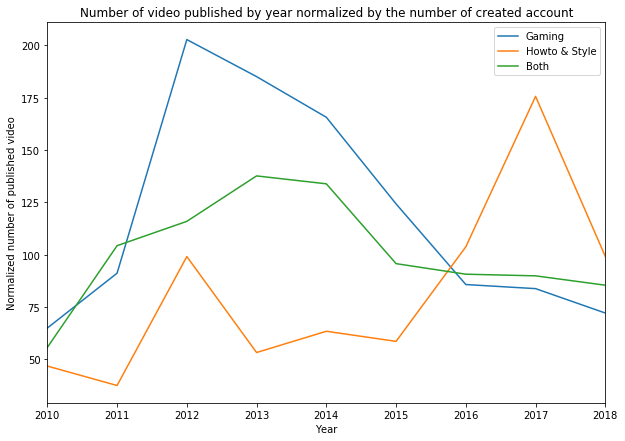

In [7]:
# Define a function 
def normalized_channel(youtube_A, cat):
    video_cat = youtube_A[youtube_A['channel_cat'] == cat]
    # Counts the number of published video in gaming cat
    upload_year_counts = video_cat['upload_year'].value_counts()
    # Counts the number of channel created from 2010 in gaming
    channels = video_cat.groupby('channel').agg(created_date=('upload_year', 'min'))
    created_channel_counts = channels['created_date'].value_counts()
    # For gaming there are no new channel in 2018
    # We will then add a 0 before the cum sum
    for year in range(2010, 2019):
        if year not in created_channel_counts.index:
            created_channel_counts[year] = 0
    # Cumulative sum
    created_channel_counts = created_channel_counts.cumsum()
    # Compute the ratio
    return upload_year_counts/created_channel_counts

# Gamming channels
nomralized_video_counts_gaming = normalized_channel(youtube_A, "Gaming")
# How to channels
nomralized_video_counts_howto = normalized_channel(youtube_A, "Howto & Style")
# Both
nomralized_video_counts_both = upload_year_counts/new_channels_counts

# plot results
plt.figure(figsize=(10, 7))
nomralized_video_counts_gaming.plot(label="Gaming")
nomralized_video_counts_howto.plot(label="Howto & Style")
nomralized_video_counts_both.plot(label="Both")
plt.title("Number of video published by year normalized by the number of created account")
plt.xlabel("Year")
plt.ylabel("Normalized number of published video")
plt.legend()
plt.show()

If we look at the graph regrouping both categories we can see that the number grows from 2010 to 2014 and the decrease (it's because the number of published video remains constant while the number of accounts increase).

But if we look at the graph per category we can see that the number of video published in gaming which was 200 videos per channel in 2012 has decrease a lot to end up with less than 75 videos per channel in 2018.

For the How to category th e normalized number of published video has grown up until 2017 and then there is a big drop in 2018.

So yes we can conclude that in general the channels have became less and less acitve.

## A2: The one thing we all love: cash money

Your friend is really keen on making money from their YouTube channel through ads and wants you to help them choose the most profitable channel category (Gaming or Howto & Style). The ad profit is directly proportional to the number of views of a video.

1. Since your friend wants to keep producing videos for several years to come, it might also be worth looking at the growth of the two categories.
  1. Compute the total number of views in each category per year for the years 2010-2018.
  2. Divide the yearly view count by the number of channels that posted a video in each category in each year. Plot these normalized counts.




In [8]:
# A : number of view per year per category
view_counts_cat = youtube_A.groupby(['channel_cat', 'upload_year']).agg(total_view = ('view_count', 'sum'))

In [9]:
# B : Normalize
number_active_channel = youtube_A.groupby(['channel_cat', 'upload_year']).agg(total_view = ('channel', 'count'))

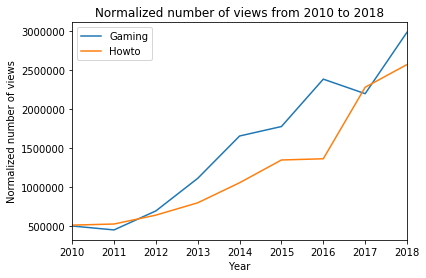

In [10]:
# Compute the ratio
normalized_view_counts = view_counts_cat/number_active_channel

plt.figure()
normalized_view_counts.loc['Gaming']['total_view'].plot(label="Gaming")
normalized_view_counts.loc['Howto & Style']['total_view'].plot(label="Howto")
plt.title("Normalized number of views from 2010 to 2018")
plt.xlabel("Year")
plt.ylabel("Normalized number of views")
plt.legend()
plt.show()

We can see that the number of views has increased a lot since 2010 for both categories. Gaming has always had more views than How to excpet in 2017. It's the only year where the number of views decreased.

2. Your friend's channel will be brand new, so you decide to look more closely at newer channels. For this question and all the following questions in A2, only consider channels that uploaded their first video in  2016 or later. Compute the total number of views in each category and divide it by the number of channels in that category.


In [11]:
# Get the list of the new channels
new_channels = youtube_A.groupby('channel').agg(created_date=('upload_year', 'min'))
new_channels = new_channels[new_channels['created_date'] > 2015].index.to_list()

# Keep only videos from these new channels
videos_new_channels = youtube_A[youtube_A['channel'].isin(new_channels)]

In [12]:
view_counts_cat = videos_new_channels.groupby(['channel_cat']).agg(total_view = ('view_count', 'sum'))
number_active_channel = videos_new_channels.groupby(['channel_cat']).agg(total_view = ('channel', 'count'))
# Compute the ratio
normalized_view_counts = view_counts_cat/number_active_channel
normalized_view_counts

,total_view
channel_cat,
Gaming,1.433777e+06
Howto & Style,2.547726e+06


We can see here that the number of views is much higher int the How to category than in the gaming categroy.

3. The number of views might be very unevenly over the different channels, and channels might upload different numbers of videos.
  1. Compute the mean number of views per video for each channel.
  2. Compute the mean of these means for each of the two categories. Print these values.
  3. Using bootstrapping, compute 95% confidence intervals for these two means. From this analysis, can you draw a recommendation for one of the two categories? Why, or why not?

In [13]:
mean_view_channel = videos_new_channels.groupby(['channel_cat', 'channel']).agg(mean_view=('view_count', 'mean'))
mean_view_gaming = mean_view_channel.loc['Gaming'].mean()
mean_view_howto = mean_view_channel.loc['Howto & Style'].mean()
print("Mean of view in gaming : ", mean_view_gaming.values[0].round(2))
print("Mean of view in howto  : ", mean_view_howto.values[0].round(2))

Mean of view in gaming :  1444658.13
Mean of view in howto  :  3965565.14


Here we still can see that how to has a higher mean of number of views

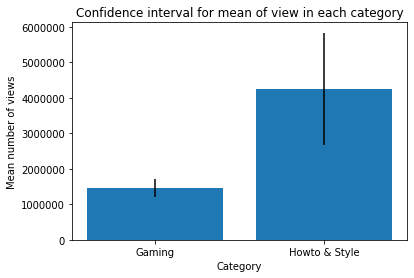

In [14]:
from scipy import stats

def compute_bootstrap_CI(sample, n=100):
    results = sample.sample(n, replace=True)['mean_view'].to_list()
    mean = np.mean(results)
    std = np.std(results)
    t = stats.t.ppf(1-0.025, n-1)
    confidence = t * std / np.sqrt(n)
    return mean, confidence

mean_gaming, confidence_gaming = compute_bootstrap_CI(mean_view_channel.loc['Gaming'])
mean_howto, confidence_howto = compute_bootstrap_CI(mean_view_channel.loc['Howto & Style'])

plt.figure()
plt.bar(x=['Gaming', 'Howto & Style'], height=[mean_gaming, mean_howto], yerr=[2*confidence_gaming, 2*confidence_howto])
plt.title("Confidence interval for mean of view in each category")
plt.xlabel("Category")
plt.ylabel("Mean number of views")
plt.show()

It's clear here that the howto & style category is better than gaming in terms of number of views because the lower bound of the confidence interval of the howto categroy is higher than the upper bound of the gaming confidence interval.

# Task B: View forecasting (Machine Learning)

Your friend wants to figure out how they can optimize their videos for getting the maximum number of views (without using shocking thumbnails and clickbait titles). In this task, you will build a machine learning (ML) model for predicting the success of a video.

## B1: Get those shovels out again

1. For the prediction model, use all rows of the dataset, but keep only the following columns: `view_count, channel, upload_date, duration, average_rating, height, width`.

In [15]:
youtube_B = youtube[['view_count', 'channel', 'upload_date', 'duration', 'average_rating', 'height', 'width']]

2. Extract the upload year and upload month from the `upload_date` column into the two columns `upload_year` and `upload_month`, and remove `upload_date`.

In [16]:
youtube_B['upload_year'] = pd.DatetimeIndex(youtube_B['upload_date']).year
youtube_B['upload_month'] = pd.DatetimeIndex(youtube_B['upload_date']).month
youtube_B = youtube_B.drop(columns='upload_date')
youtube_B.head()

/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,view_count,channel,duration,average_rating,height,width,upload_year,upload_month
0,2541550.0,PewDiePie,1126.0,4.886102,720.0,1280.0,2013,3
1,1727646.0,PewDiePie,903.0,4.951531,720.0,1280.0,2013,3
2,1402747.0,PewDiePie,806.0,4.962706,720.0,1280.0,2013,3
3,4348296.0,PewDiePie,909.0,4.937665,720.0,1280.0,2013,3
4,1410659.0,PewDiePie,834.0,4.957545,720.0,1280.0,2013,3


3. The entry in the channel column for a video indicates on which channel the video was uploaded. Encode this column via one-hot encoding.

In [17]:
youtube_B = pd.get_dummies(youtube_B)
youtube_B.head()

,view_count,duration,average_rating,height,width,upload_year,upload_month,channel_5-Minute Crafts,channel_5-Minute Crafts GIRLY,channel_5-Minute Crafts PLAY,...,channel_grav3yardgirl,channel_iHasCupquake,channel_jacksepticeye,channel_jaipurthepinkcity,channel_jeffreestar,channel_speedyw03,channel_stampylonghead,channel_theRadBrad,channel_videogamedunkey,channel_windy31
0,2541550.0,1126.0,4.886102,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1727646.0,903.0,4.951531,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1402747.0,806.0,4.962706,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4348296.0,909.0,4.937665,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1410659.0,834.0,4.957545,720.0,1280.0,2013,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4. Split the data into a train (70%) and a test set (30%) with the appropriate function from sklearn, using 42 as the random seed.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(youtube_B.drop(columns='view_count'), youtube_B['view_count'], test_size=0.3, random_state=42)

## B2: Who is the most viewed of them all?

1. Train a ridge regression model (i.e., an L2-regularized linear regression model) on the train set that predicts the view count from the other features. Find and use the optimal regularization parameter $\alpha$ from the set {0.001, 0.01, 0.1} via 3-fold cross validation.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_dict = {'alpha':[0.001, 0.01, 0.1]}
model = Ridge()
grid_search = GridSearchCV(model, param_dict, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# We put a - because the score is the neg mean abs error
best_score = -grid_search.best_score_
best_alpha = grid_search.best_params_['alpha']

In [20]:
print("The best model is obtained using alpha = {} and has a MSE of : {}".format(best_alpha, best_score))

The best model is obtained using alpha = 0.1 and has a MSE of : 1512092.9715274125


2. Report the mean absolute error that the model makes on the test set.

In [21]:
from sklearn.metrics import mean_absolute_error

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error on the test set is : ", mae)

The Mean Absolute Error on the test set is :  1444649.5039951287


It means that we can predict the true number of view with an average error of 1.5 millions view

## B3: Checking our ambitions

To improve performance, you want to make the task of the ML model easier and turn it into a classification task. Now it only has to predict whether a video has a high view count (defined as being larger than the median of the view counts in the training set) or a low view count (defined as being smaller or equal to the median of the view counts in the training set).

1. Train a logistic regression model for this classification task. Find and use the optimal regularization parameter C (as defined in scikit-learn's documentation) from the set {1, 10, 100} via 3-fold cross validation. Use the random seed 42. _Hint_: If you get a warning about the training algorithm failing to converge, increase the maximum number of training iterations.

In [22]:
median = y_train.median()
# Transform y in 1 if high and 0 if low
y_train_class = (y_train > median).astype('int')
y_test_class =(y_test > median).astype('int')

In [23]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(Cs=[1, 10, 100], cv=3, random_state=42, max_iter=500).fit(X_train, y_train_class)
print("Best C :", model.C_[0])

Best C : 1


2. Compute the accuracy of the logistic regression model on the test set.

In [24]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print("Accuracy on the test set :", accuracy_score(y_test_class, y_pred))

Accuracy on the test set : 0.7479033761020716


## B4: ...something's not right.

You are satisfied with the model performance. In fact, you are a bit surprised at how good the model is given the relatively little amount of information about the videos. So you take a closer look at the features and realize that the (one-hot-encoded) channel feature does not make sense for the application that your friend has in mind.

1. Why does the channel feature not make sense?

Because for him this value will be always different from the ones in the dataset (it will published his video using his own channel). And he cannot change the value of his parameter.

2. Train another logistic regression model with all the features from B3 except the one-hot-encoded channel. Use again 42 as the seed for the train test split and perform the same hyperparameter optimization as in B3. How does the model performance change?

In [25]:
# Now do not keep the channel column
youtube_B = youtube[['view_count', 'upload_date', 'duration', 'average_rating', 'height', 'width']]
youtube_B['upload_year'] = pd.DatetimeIndex(youtube_B['upload_date']).year
youtube_B['upload_month'] = pd.DatetimeIndex(youtube_B['upload_date']).month
youtube_B = youtube_B.drop(columns='upload_date')

/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
def test_model(youtube):
    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(youtube.drop(columns='view_count'), youtube['view_count'], test_size=0.3, random_state=42)

    # Discretize classes
    median = y_train.median()
    y_train_class = (y_train > median).astype('int')
    y_test_class =(y_test > median).astype('int')

    # Perform cross validation to find the best C and fit the model
    model = LogisticRegressionCV(Cs=[1, 10, 100], cv=3, random_state=42, max_iter=500).fit(X_train, y_train_class)
    print("Best C :", model.C_[0])

    # Test the model
    y_pred = model.predict(X_test)
    print("Accuracy on the test set :", accuracy_score(y_test_class, y_pred))

test_model(youtube_B)

Best C : 100
Accuracy on the test set : 0.6075311208276587


We can see that the model changed a lot ! The accuracy dropped from 75% to only 60% which is not very good for a machine learning model.

## B5: "We kinda forgot about categories."

On second thought, there is actually one feature that you may use about the channel. Namely, the channel category. The reason this one makes sense might also help you answer B4.1.

1. Train and evaluate another logistic regression model (in the same way as in B4 regarding train/test split and hyperparameter) that additionally includes the one-hot-encoded channel category.

In [27]:
# Now do keep the channel category column
youtube_B = youtube[['view_count', 'upload_date', 'duration', 'average_rating', 'height', 'width', 'channel_cat']]
youtube_B['upload_year'] = pd.DatetimeIndex(youtube_B['upload_date']).year
youtube_B['upload_month'] = pd.DatetimeIndex(youtube_B['upload_date']).month
youtube_B = youtube_B.drop(columns='upload_date')
youtube_B = pd.get_dummies(youtube_B)
youtube_B.head()

/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lamborellemaxime/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,view_count,duration,average_rating,height,width,upload_year,upload_month,channel_cat_Gaming,channel_cat_Howto & Style
0,2541550.0,1126.0,4.886102,720.0,1280.0,2013,3,1,0
1,1727646.0,903.0,4.951531,720.0,1280.0,2013,3,1,0
2,1402747.0,806.0,4.962706,720.0,1280.0,2013,3,1,0
3,4348296.0,909.0,4.937665,720.0,1280.0,2013,3,1,0
4,1410659.0,834.0,4.957545,720.0,1280.0,2013,3,1,0


In [28]:
test_model(youtube_B)

Best C : 1
Accuracy on the test set : 0.6168016629632285


2. The dynamics of the two categories might differ a lot, and the two communities might value different properties of a video differently. For instance, for one community, a long duration might be more important, for the other one, a large picture width. Thus, having only a single weight for, e.g., the duration of a video, might not give the best results. Is there something smarter that you can do than simply including the category as a single one-hot-encoded feature to improve the classification performance? Implement your idea and compare the accuracy on the test set with that of the first model (from task B5.1).

# Task C: A map of the channels (Graphs)

Your friend wants to map out the channels and represent their similarities. For this purpose, we have created two undirected and unweighted graphs for you, where in each graph, each channel has a node and similar channels have edges connecting them. In one graph, the similarity between two channels is based on how similar their video descriptions are, while in the other, the similarity is based on how similar their video tags are. We will call the former $G_{text}$ and the latter $G_{tags}$. You will be analyzing the two graphs loaded by running the cell below.

In [29]:
from networkx import from_numpy_array
import json
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = from_numpy_array(g_text_adj)
g_tags = from_numpy_array(g_tags_adj)

## C1: Does YouTube have a content diversity problem?

1. For each graph, calculate its diameter (i.e., the largest shortest-path length, where the maximization is done over all node pairs). What difference do you see? _Hint_: Don't worry if you get an error, just read the error message carefully.

In [30]:
if nx.is_connected(g_text):
    print("Diameter of tags graph :", nx.diameter(g_text))
else:
    print("The graph is not connected")

Diameter of tags graph : 2


In [31]:
if nx.is_connected(g_tags):
    print("Diameter of tags graph :", nx.diameter(g_tags))
else:
    print("The graph is not connected")

The graph is not connected


The text graph is connected while the tags graph is not (it then has no diameter)

2. What does the diameter of $G_{text}$ say about the diversity of the channels’ contents? How about the diameter of $G_{tags}$?

The content are very close from each other because the longuest shortest path is only two.
Using the tags it's easier to distinguish communities in the graph because it is not connected.

3. Based on what you have calculated, which one has greater diversity: descriptions used by channels, or tags used by channels? Justify your answer.

The tags used by the channels because the graph using the tags is not connected. It means that some videos are absolutely not related if we only look at that graph. Moreover because it's not connected, the diameter is infinite so it's another way to see that the diversity is bigger.

4. Imagine that you want to **compare** content diversity between two sets of channels (i.e., you want to see which set of channels has more diverse content), and you have calculated a tag-based graph for each set. Do you think the diameter is a good measure for doing the comparison? Justify your answer.

No because as soon as the graph is not connected anymore the diameter becomes infinite and it's not possible anymore to compare the two set of channels.

5. Back to our own two graphs. Based on $G_{text}$, for each category of channels, which channel is the one most representative of the contents of all channels in that category? In other words, for each category, if you needed to provide a summary of all channels in the category via one channel, which channel would you choose? Show us (us being the exam designers and your friend) the descriptions of this channel’s two most-viewed videos. What metric did you use for this purpose? Explain your choice.

In [32]:
import json
# We will relabel nodes
with open('data/channel_indices.json') as f:
    indices = json.load(f)

g_text = nx.relabel_nodes(g_text, {k:v for k,v in enumerate(indices)})
g_tags = nx.relabel_nodes(g_tags, {k:v for k,v in enumerate(indices)})

In [33]:
# get cat for each channel
channel_cat = youtube.groupby('channel').agg(cat=('channel_cat', lambda x:x.mode()[0]))

In [34]:
nx.set_node_attributes(g_text, channel_cat['cat'].to_dict(), 'category' )
nx.set_node_attributes(g_tags, channel_cat['cat'].to_dict(), 'category' )

In [38]:
gaming_graph = nx.subgraph(g_text, [node for node in g_text.nodes if g_text.nodes[node]['category'] == "Gaming"])
howto_graph = nx.subgraph(g_text, [node for node in g_text.nodes if g_text.nodes[node]['category'] == "Howto & Style"])

We will use the most central node. Here we will use the betweeness centrality.

In [41]:
from networkx.algorithms.centrality import betweenness_centrality

#Gaming graph
max(betweenness_centrality(gaming_graph), key=lambda x:x[1])

'Azerrz'

In [42]:
max(betweenness_centrality(howto_graph), key=lambda x:x[1])

'Izabela Stress'

## C2: Going back to categories again

1. We want to use the two graphs to cluster channels from the same category together, and we want to compare their effectiveness at doing so. Use Kernighan-Lin bisection in the networkx package (`networkx.algorithms.community.kernighan_lin_bisection`) to divide each graph into two communities. Use 42 as the random seed. For each graph, show how many members of each category fall into each of the two communities.

In [46]:
from networkx.algorithms.community import kernighan_lin_bisection
communities = kernighan_lin_bisection(g_text)

gaming = 0
howto = 0
for node in communities[0]:
    if g_text.nodes[node]['category'] == 'Gaming':
        gaming += 1
    else:
        howto += 1

print("In the first community there are {} from gaming and {} from howto".format(gaming, howto))

In the first community there are 69 from gaming and 28 from howto


In [47]:
gaming = 0
howto = 0
for node in communities[1]:
    if g_text.nodes[node]['category'] == 'Gaming':
        gaming += 1
    else:
        howto += 1

print("In the second community there are {} from gaming and {} from howto".format(gaming, howto))

In the second community there are 30 from gaming and 68 from howto


In [49]:
# Tags graph
communities = kernighan_lin_bisection(g_tags)
gaming = 0
howto = 0
for node in communities[0]:
    if g_tags.nodes[node]['category'] == 'Gaming':
        gaming += 1
    else:
        howto += 1

print("In the first community there are {} from gaming and {} from howto".format(gaming, howto))

gaming = 0
howto = 0
for node in communities[1]:
    if g_tags.nodes[node]['category'] == 'Gaming':
        gaming += 1
    else:
        howto += 1

print("In the second community there are {} from gaming and {} from howto".format(gaming, howto))

In the first community there are 18 from gaming and 79 from howto
In the second community there are 81 from gaming and 17 from howto


The best is the tags graph as it minimize then entropy in the communities.

2. If one of these graphs were ideal for this clustering task, what would the resulting communities look like? If it were the absolute worst possible graph for the task, what would the resulting communities look like?

3. Calculate the probability $P(community|category)$ for each community and category within each graph. Design a metric, using the four $P(community|category)$ values in a graph, whose value would be 1 for the ideal graph and 0 for the worst graph. Calculate this metric for both graphs and compare the two. What do the results say about how representative tags and descriptions are regarding the channel categories? Are tags better suited, or descriptions?

4. The Kernighan-Lin bisection you used above performs a min-edge cut: It attempts to partition the nodes of the graph into two sets of almost-equal size by deleting as few edges as possible. It starts off by creating a random partition of the nodes of the graph into two sets A and B that are almost equal in size, and then iteratively and in a greedy fashion moves nodes between A and B to reduce the number of edges between A and B. Show at least one toy example of a graph where the initialization could also be the final result. (Hint: Think of how, as we explained, the bisection algorithm relies on a minimum edge cut with a random initialization; under what circumstances could the original A and B be the best partition given that graph?)